In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib

In [ ]:
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file(origin=dataset_url,
                                 fname='flower_photos',
                                 untar=True)
data_dir=pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


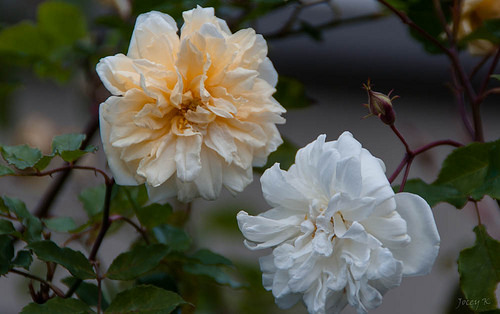

In [ ]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(roses[0])

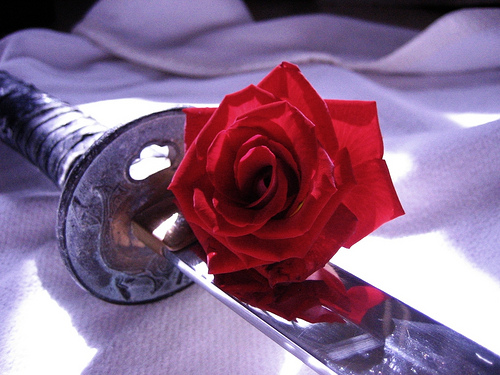

In [ ]:
PIL.Image.open(roses[1])

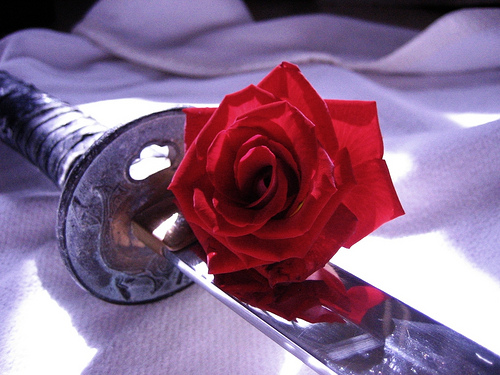

In [ ]:
PIL.Image.open(str(roses[1]))

In [ ]:
batch_size=32
img_height=180
img_width=180
seed=123

In [ ]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             validation_split=0.2,
                                                             batch_size=batch_size,
                                                             image_size=(img_height,img_width),
                                                             seed=seed,
                                                             subset='training')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                           batch_size=batch_size,
                                                           image_size=(img_height,img_width),
                                                           seed=seed,
                                                           validation_split=0.2,
                                                           subset='validation')

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


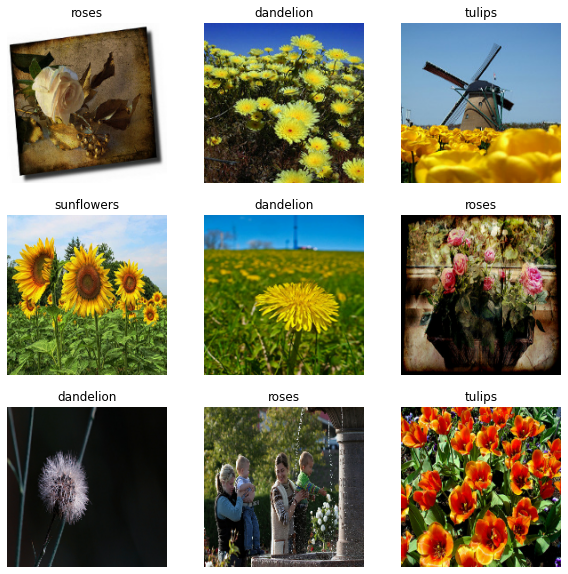

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))

In [ ]:
image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 0.96902645


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes=5

model=tf.keras.Sequential([
                           tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                           tf.keras.layers.Conv2D(32,3,activation='relu'),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Conv2D(32,3,activation='relu'),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Conv2D(32,3,activation='relu'),
                           tf.keras.layers.MaxPooling2D(),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=3)

Epoch 1/3
92/92 [==============================] - 120s 1s/step - loss: 1.3648 - accuracy: 0.4040 - val_loss: 1.1452 - val_accuracy: 0.5123
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 1.0602 - accuracy: 0.5732 - val_loss: 1.0231 - val_accuracy: 0.5845
Epoch 3/3
92/92 [==============================] - 112s 1s/step - loss: 0.9237 - accuracy: 0.6488 - val_loss: 0.9608 - val_accuracy: 0.6240


In [ ]:
# plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True)

In [ ]:
list_ds=tf.data.Dataset.list_files(str(data_dir/'*/*'),shuffle=False)
list_ds=list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/3440366251_5b9bdf27c9_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/2440874162_27a7030402_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3773181799_5def396456.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/2476098674_e6f39536f5_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/8174970894_7f9a26be7e.jpg'


In [ ]:
class_names=np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
val_size=int(image_count*0.2)
train_ds=list_ds.skip(val_size)
val_ds=list_ds.take(val_size)

In [ ]:
len(train_ds)

2936

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(train_ds).numpy())

2936
2936


In [ ]:
def get_label(file_path):
  parts=tf.strings.split(file_path,os.path.sep)
  one_hot=parts[-2]==class_names
  return tf.argmax(one_hot)

In [ ]:
def decode_image(img):
  img=tf.io.decode_jpeg(img,channels=3)
  return tf.image.resize(img,[img_height,img_width])

In [ ]:
def process_path(file_path):
  label=get_label(file_path)
  img=tf.io.read_file(file_path)
  img=decode_image(img)
  return img,label

In [ ]:
train_ds=train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [ ]:
for image,label in train_ds.take(1):
  print('image shape:',image.numpy().shape)
  print('label:',label.numpy())

image shape: (180, 180, 3)
label: 3


In [ ]:
def configure_for_performance(ds):
  ds=ds.cache()
  ds=ds.shuffle(buffer_size=1000)
  ds=ds.batch(batch_size)
  ds=ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
train_ds=configure_for_performance(train_ds)
val_ds=configure_for_performance(val_ds)

In [ ]:
image_batch,labels_batch=next(iter(train_ds))

In [ ]:
image_batch.shape

TensorShape([32, 180, 180, 3])

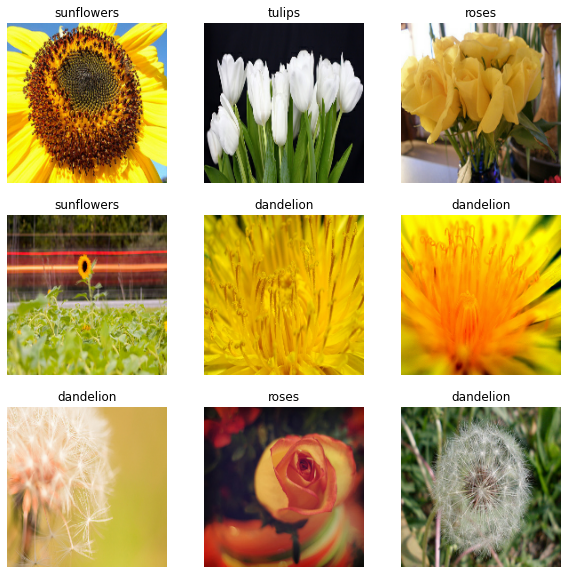

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  label=labels_batch[i]
  plt.title(class_names[label])
  plt.axis('off')

In [ ]:
jet=model.fit(train_ds,
              validation_data=val_ds,
              epochs=4)

Epoch 1/4
92/92 [==============================] - 123s 1s/step - loss: 0.8049 - accuracy: 0.6999 - val_loss: 0.8340 - val_accuracy: 0.6866
Epoch 2/4
92/92 [==============================] - 113s 1s/step - loss: 0.6090 - accuracy: 0.7779 - val_loss: 0.7966 - val_accuracy: 0.6935
Epoch 3/4
92/92 [==============================] - 117s 1s/step - loss: 0.4406 - accuracy: 0.8409 - val_loss: 0.8489 - val_accuracy: 0.6853
Epoch 4/4
92/92 [==============================] - 115s 1s/step - loss: 0.2738 - accuracy: 0.9046 - val_loss: 1.0050 - val_accuracy: 0.6757
